In [1]:
from mcts_real import *

2024-09-09 14:37:22.357463: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-09 14:37:23.390866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-09-09 14:37:23.449390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-09 14:37:23.449523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 76 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 667.63GiB/s
2024-09-09 14:37:23.449544: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-09 14:37:23.451496: I tensorflow/stream_executor/

Failed to import pyassimp, see https://github.com/moveit/moveit/issues/86 for more info


In [2]:
parser = ArgumentParser()
# Data directory
parser.add_argument('--data-dir', type=str, default='/ssd/disk')
# Inference
parser.add_argument("--seed", default=None, type=int)
parser.add_argument('--num-objects', type=int, default=5)
parser.add_argument('--num-scenes', type=int, default=10)
parser.add_argument('--H', type=int, default=12)
parser.add_argument('--W', type=int, default=15)
parser.add_argument('--crop-size', type=int, default=128) #96
parser.add_argument('--gui-off', action="store_true")
parser.add_argument('--visualize-graph', action="store_true")
parser.add_argument('--logging', action="store_true")
# MCTS
parser.add_argument('--algorithm', type=str, default='mcts') # 'mcts' / 'alphago'
parser.add_argument('--time-limit', type=int, default=None)
parser.add_argument('--iteration-limit', type=int, default=2000)
parser.add_argument('--max-depth', type=int, default=7)
parser.add_argument('--rollout-policy', type=str, default='nostep') # 'nostep' / 'policy' / 'iql-policy'
parser.add_argument('--tree-policy', type=str, default='random') # 'random' / 'policy' / 'iql-policy'
parser.add_argument('--puct-lambda', type=float, default=0.5)
parser.add_argument('--threshold-success', type=float, default=0.85) #0.85
parser.add_argument('--threshold-prob', type=float, default=1e-5)
parser.add_argument('--batch-size', type=int, default=32)
parser.add_argument('--binary-reward', action="store_true")
parser.add_argument('--blurring', type=int, default=3)
parser.add_argument('--exploration', type=float, default=20) # 5 for alphago / 0.5 for mcts
parser.add_argument('--gamma', type=float, default=1)
parser.add_argument('--classes', type=str, default="Apple. Lemon. Orange. Fruit.")
# Reward model
parser.add_argument('--normalize-reward', action="store_true")
parser.add_argument('--reward-type', type=str, default='gt') # 'gt' / 'iql'
parser.add_argument('--reward-model-path', type=str, default='../mcts/data/classification-best/top_nobg_linspace_mse-best.pth')
parser.add_argument('--label-type', type=str, default='linspace')
# Pretrained Models
parser.add_argument('--qnet-path', type=str, default='')
parser.add_argument('--vnet-path', type=str, default='')
parser.add_argument('--policynet-path', type=str, default='../policy_learning/logs/0224_1815/pnet_e1.pth')
parser.add_argument('--iql-path', type=str, default='../iql/logs/0308_0121/iql_e1.pth')
parser.add_argument('--sigmoid', action='store_true')
parser.add_argument('--policy-net', type=str, default='resnet') # 'resnet' / 'transport'
parser.add_argument('--policy-version', type=int, default=-1)
parser.add_argument('--continuous-policy', action='store_true')
args = parser.parse_args(args=[])


args.iteration_limit = 2000
args.tree_policy = 'random'
args.logging = True
args.classes = "Glass.Cup.Bowl.Basket.Plate.Teapot.Shampoo.Clock.Toothpaste.Tube.Box.Marker.Stapler.Vaseline.Pen.Apple.Oragne.Fruit.Scissors.Box"

In [3]:
# Logger
now = datetime.datetime.now()
log_name = now.strftime("%m%d_%H%M")
if args.logging:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

logname = 'MCTS-'
logname += args.tree_policy
if args.tree_policy=='iql':
    logname += '_' + str(args.threshold_prob)

def print_fn(s=''):
    if args.logging: 
        logger.info(s)
        print(s)
    else: 
        print(s)

# Random seed
seed = args.seed
if seed is not None:
    print_fn("Random seed: %d"%seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
# Environment setup
env = RealEnvironment(args)

# MCTS setup
renderer = Renderer(tableSize=(args.H, args.W), imageSize=(360, 480), cropSize=(args.crop_size, args.crop_size))
searcher = MCTS(renderer, args, explorationConstant=args.exploration) #1/np.sqrt(2)

# Network setup
model_path = args.reward_model_path
gtRewardNet, preprocess = loadRewardFunction(model_path)
searcher.setGTRewardNet(gtRewardNet)
searcher.setPreProcess(preprocess)

# IQL policy
if args.algorithm=='alphago':
    valuenet = loadIQLValueNetwork(args.iql_path, args)
    valuenet = valuenet.to("cuda:0")
    searcher.setValueNet(valuenet)

# Reward function
if args.reward_type=='iql':
    rnet = loadIQLRewardNetwork(args.iql_path, args, args.sigmoid)
    rnet = rnet.to("cuda:0")
    searcher.setRewardNet(rnet)

# Policy-based MCTS
if args.tree_policy.startswith('policy') or args.rollout_policy.startswith('policy'):
    pnet = loadPolicyNetwork(args.policynet_path, args)
    pnet = pnet.to("cuda:0")
    searcher.setPolicyNet(pnet)
elif args.tree_policy.startswith('iql') or args.rollout_policy.startswith('iql'):
    pnet = loadIQLPolicyNetwork(args.iql_path, args)
    pnet = pnet.to("cuda:0")
    searcher.setPolicyNet(pnet)


/home/ur-plusle/Desktop/contact_graspnet/pointnet2/tf_ops/sampling
--- Get model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
('loading ', '/home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054


2024-09-09 14:37:28.979167: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 14:37:28.979861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-09 14:37:28.979939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 76 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 667.63GiB/s
2024-09-09 14:37:28.979959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1)

Activation completed. Activation time :  1.1200053691864014
T_eef_to_rs: [[-0.99947274 -0.03222087 -0.0040074   0.04060558]
 [ 0.0323047  -0.99921361 -0.02299073  0.05245131]
 [-0.00326346 -0.02310807  0.99972765  0.09001056]
 [ 0.          0.          0.          1.        ]]
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Add bias: [0, 0, 0]


In [5]:
success = 0
success_eplen = []
best_scores = []
log_dir = 'data/%s' %args.algorithm

Error: (inverse kinematics) failed to get ik solution


Before NMS: 5 boxes
After NMS: 4 boxes
1


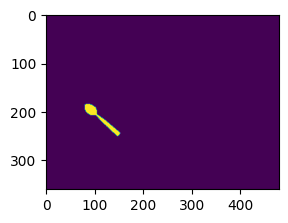

2


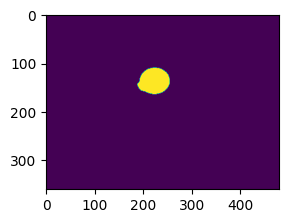

3


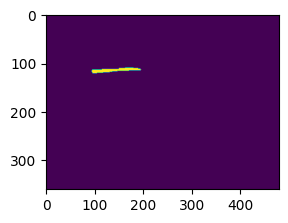

4


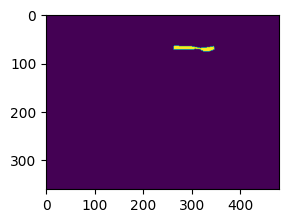

['Tube' 'Bowl' 'Tube' 'Tube']


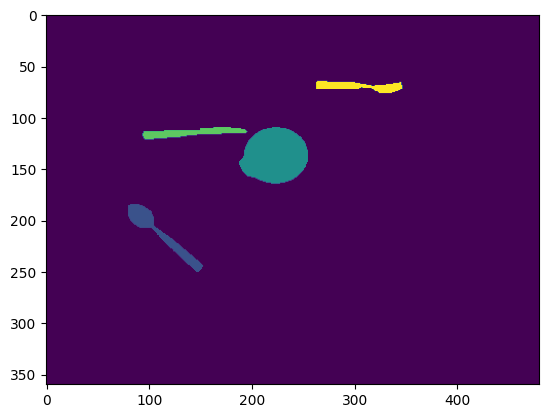

In [8]:
classes = args.classes.replace(" ", "").replace(",", ".").split(".")
obs = env.reset(classes)
initRgb = obs['rgb']
initSeg = obs['segmentation']

remove_indices = []
NB = np.max(obs['segmentation']).astype(int)
for i in range(1, NB+1):
    print(i)
    plt.figure(figsize=(3,5))
    plt.imshow(obs['segmentation']==i)
    plt.show()

    num_pixels = (env.current_obs['segmentation']==i).sum()
    if num_pixels < 300 or num_pixels > 20000:
        remove_indices.append(i)
# x = input("Which objects to remove? ")
# try:
#     remove_indices = [int(idx) for idx in x.replace(" ", "").split(",")]
# except:
#     remove_indices = []

offset = 0
for idx in remove_indices:
    env.current_obs['segmentation_raw'][env.current_obs['segmentation_raw']==idx-offset] = 0
    env.current_obs['segmentation_raw'][env.current_obs['segmentation_raw']>idx-offset] -= 1

    env.current_obs['segmentation'][env.current_obs['segmentation']==idx-offset] = 0
    env.current_obs['segmentation'][env.current_obs['segmentation']>idx-offset] -= 1

    env.current_obs['class_id'] = np.concatenate([env.current_obs['class_id'][:idx-offset-1], env.current_obs['class_id'][idx-offset:]])
    offset += 1

print(np.array(classes)[env.current_obs['class_id']])
plt.imshow(env.current_obs['segmentation'])
plt.show()

initTable: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
--------------------------------
Num Children: 165
2.1226251125335693 seconds to search.
Total nodes: 870
Depth 0: 1 nodes, 2000 visits
Depth 1: 165 nodes, 2000 visits
Depth 2: 454 nodes, 889 visits
Depth 3: 233 nodes, 262 visits
Depth 4: 17 nodes, 18 visits

Action coverage: 0.224357
Best Action: (4, 3, 10, 2)
Expected Q-mean: 0.287317 / Q-norm: 0.000000
Terminal: False
Best Child: 
 [[0. 0. 0. 0. 0. 0. 0.

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03243463 -0.99946558 -0.00405289 -0.13152051]
 [-0.93172107 -0.02876812 -0.36203338 -0.73916854]
 [ 0.36172333  0.01551859 -0.93215634  0.2774931 ]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03243463 -0.99946558 -0.00405289 -0.13172315]
 [-0.93172107 -0.02876812 -0.36203338 -0.75727021]
 [ 0.36172333  0.01551859 -0.93215634  0.23088528]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.90554965 -0.94630867  1.23705161 -2.21438122 -1.45542741  4.36654407]
[-0.13152051 -0.73916854  0.2774931 ]
[ 0.70593184 -0.68391402  0.12666607  0.13370695]
Find solutions: [-1.89767277 -0.86632735  1.22630501 -2.28446221 -1.45815253  4.37398273]
[-0.13172315 -0.75727021  0.23088528]
[ 0.70593184 -0.68391402  0.12666607  0.13370695]
Find solutions: [-1.90554965 -0.94630867  1.23705161 -2.21438122 -1.45542741  4.36654407]
[-0.13152051 -0.73916854  0.2774931 ]
[ 0.70593184 -0.68391402  0.12666607  0.13370695]


Error: (inverse kinematics) failed to get ik solution


There's a wrong phrase happen, this is because of our post-process merged wrong tokens, which will be modified in the future. We will assign it with a random label at this time.
Before NMS: 6 boxes
After NMS: 4 boxes
Current state: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Current Score: 0.105370
--------------------------------
Counts:
num inference: 869
total nodes: 792
num duplicate nodes: 67
total duplicates: 145

Num Children: 168
2.3294661045074463 seco

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03145893 -0.99949327 -0.00485141  0.25083919]
 [-0.93174308 -0.02756906 -0.3620698  -0.59093274]
 [ 0.36175261  0.0159106  -0.93213823  0.23193775]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03145893 -0.99949327 -0.00485141  0.25059662]
 [-0.93174308 -0.02756906 -0.3620698  -0.60903623]
 [ 0.36175261  0.0159106  -0.93213823  0.18533083]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.32830966 -1.1369071   1.67023885 -2.46361351 -1.66257393  4.90763277]
[ 0.25083919 -0.59093274  0.23193775]
[ 0.70554346 -0.68430811  0.12646324  0.13393238]
Find solutions: [-1.33567488 -1.0760597   1.64051533 -2.495363   -1.65998065  4.90071077]
[ 0.25059662 -0.60903623  0.21      ]
[ 0.70554346 -0.68430811  0.12646324  0.13393238]
Find solutions: [-1.32830966 -1.1369071   1.67023885 -2.46361351 -1.66257393  4.90763277]
[ 0.25083919 -0.59093274  0.23193775]
[ 0.70554346 -0.68430811  0.12646324  0.13393238]


Error: (inverse kinematics) failed to get ik solution


Before NMS: 6 boxes
After NMS: 4 boxes
Current state: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Current Score: 0.277286
--------------------------------
Counts:
num inference: 1043
total nodes: 929
num duplicate nodes: 90
total duplicates: 205

Num Children: 168
2.791053295135498 seconds to search.
Total nodes: 1249
Depth 0: 1 nodes, 2000 visits
Depth 1: 168 nodes, 2000 visits
Depth 2: 682 nodes, 1262 visits
Depth 3: 362 nodes, 425 visits
Depth 4: 34 nodes, 3

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03279303 -0.99945651 -0.00334357 -0.15293942]
 [-0.9319152  -0.02936763 -0.36148583 -0.53597025]
 [ 0.36119115  0.01497014 -0.93237188  0.22733665]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03279303 -0.99945651 -0.00334357 -0.1531066 ]
 [-0.9319152  -0.02936763 -0.36148583 -0.55404454]
 [ 0.36119115  0.01497014 -0.93237188  0.18071805]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-2.07162857 -1.31443846  1.93100178 -2.51672029 -1.39932072  4.20794779]
[-0.15293942 -0.53597025  0.22733665]
[ 0.70613956 -0.68377829  0.12669151  0.13327956]
Find solutions: [-2.05565739 -1.25251138  1.90103328 -2.55125475 -1.40450597  4.22327191]
[-0.1531066  -0.55404454  0.21      ]
[ 0.70613956 -0.68377829  0.12669151  0.13327956]
Find solutions: [-2.07162857 -1.31443846  1.93100178 -2.51672029 -1.39932072  4.20794779]
[-0.15293942 -0.53597025  0.22733665]
[ 0.70613956 -0.68377829  0.12669151  0.13327956]


Error: (inverse kinematics) failed to get ik solution


Before NMS: 5 boxes
After NMS: 4 boxes
Current state: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Current Score: 0.284971
--------------------------------
Counts:
num inference: 1248
total nodes: 1135
num duplicate nodes: 91
total duplicates: 205

Num Children: 168
2.6339850425720215 seconds to search.
Total nodes: 1187
Depth 0: 1 nodes, 2000 visits
Depth 1: 168 nodes, 2000 visits
Depth 2: 631 nodes, 1211 visits
Depth 3: 340 nodes, 403 visits
Depth 4: 43 nodes,

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03121378 -0.99950696 -0.00337889 -0.09259759]
 [-0.93224811 -0.02789383 -0.36074279 -0.6096654 ]
 [ 0.36047066  0.01441011 -0.93265925  0.22554726]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03121378 -0.99950696 -0.00337889 -0.09276653]
 [-0.93224811 -0.02789383 -0.36074279 -0.62770254]
 [ 0.36047066  0.01441011 -0.93265925  0.1789143 ]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.9155947  -1.18722916  1.76260865 -2.49637032 -1.45176196  4.35808474]
[-0.09259759 -0.6096654   0.22554726]
[ 0.70564985 -0.68438871  0.12651167  0.13291042]
Find solutions: [-1.90560937 -1.13037395  1.7240057  -2.515728   -1.45519292  4.36752695]
[-0.09276653 -0.62770254  0.21      ]
[ 0.70564985 -0.68438871  0.12651167  0.13291042]
Find solutions: [-1.9155947  -1.18722916  1.76260865 -2.49637032 -1.45176196  4.35808474]
[-0.09259759 -0.6096654   0.22554726]
[ 0.70564985 -0.68438871  0.12651167  0.13291042]


Error: (inverse kinematics) failed to get ik solution


Before NMS: 5 boxes
After NMS: 4 boxes
Current state: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Current Score: 0.253786
--------------------------------
Counts:
num inference: 1186
total nodes: 1073
num duplicate nodes: 92
total duplicates: 206

Num Children: 168
2.9854681491851807 seconds to search.
Total nodes: 1280
Depth 0: 1 nodes, 2000 visits
Depth 1: 168 nodes, 2000 visits
Depth 2: 715 nodes, 1312 visits
Depth 3: 360 nodes, 414 visits
Depth 4: 33 nodes,

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03321819 -0.9994421  -0.00345328  0.22887   ]
 [-0.93174669 -0.0297178  -0.36189104 -0.5793112 ]
 [ 0.36158653  0.01523895 -0.93221415  0.25570275]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03321819 -0.9994421  -0.00345328  0.22869734]
 [-0.93174669 -0.0297178  -0.36189104 -0.59740575]
 [ 0.36158653  0.01523895 -0.93221415  0.20909204]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.36008692 -1.2049036   1.70223129 -2.43026137 -1.64994669  4.876023  ]
[ 0.22887    -0.5793112   0.25570275]
[ 0.7062489  -0.68360771  0.12677302  0.13349753]
Find solutions: [-1.36664736 -1.11432123  1.70206678 -2.5211587  -1.64762104  4.86986989]
[ 0.22869734 -0.59740575  0.21      ]
[ 0.7062489  -0.68360771  0.12677302  0.13349753]
Find solutions: [-1.36008692 -1.2049036   1.70223129 -2.43026137 -1.64994669  4.876023  ]
[ 0.22887    -0.5793112   0.25570275]
[ 0.7062489  -0.68360771  0.12677302  0.13349753]


Error: (inverse kinematics) failed to get ik solution


Before NMS: 5 boxes
After NMS: 4 boxes
Current state: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Current Score: 0.268633
--------------------------------
Counts:
num inference: 1279
total nodes: 1142
num duplicate nodes: 108
total duplicates: 246

Num Children: 168
3.4241530895233154 seconds to search.
Total nodes: 1216
Depth 0: 1 nodes, 2000 visits
Depth 1: 168 nodes, 2000 visits
Depth 2: 665 nodes, 1222 visits
Depth 3: 345 nodes, 407 visits
Depth 4: 37 nodes

Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.03322129 -0.9994423  -0.00334553 -0.06608714]
 [-0.93156748 -0.02975221 -0.36234883 -0.38431064]
 [ 0.36204722  0.01515428 -0.93203658  0.23906899]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.03322129 -0.9994423  -0.00334553 -0.06625442]
 [-0.93156748 -0.02975221 -0.36234883 -0.40242808]
 [ 0.36204722  0.01515428 -0.93203658  0.19246716]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-2.06191945 -1.73160124  2.33856535 -2.50953841 -1.40205705  4.21698243]
[-0.06608714 -0.38431064  0.23906899]
[ 0.70622413 -0.6835684   0.12697871  0.13363431]


KeyboardInterrupt: 

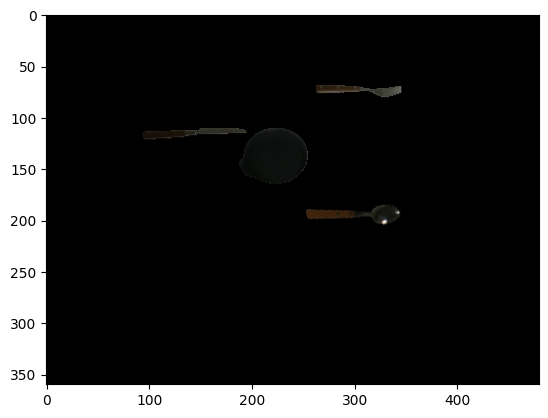

In [7]:
obs = env.current_obs
initRgb = obs['rgb']
initSeg = obs['segmentation']

sidx = 0
os.makedirs('%s-%s/scene-%d'%(log_dir, log_name, sidx), exist_ok=True)

best_score = 0.0
bestRgb = None
if args.logging:
    plt.imshow(initRgb)
    plt.savefig('%s-%s/scene-%d/initial.png'%(log_dir, log_name, sidx))
initTable = searcher.reset(initRgb, initSeg)
print_fn('initTable: \n %s' % initTable[0])
table = initTable

print_fn("--------------------------------")
for step in range(10):
    st = time.time()
    countNode.clear()
    resultDict = searcher.search(table=table, needDetails=True)
    numInference = searcher.inferenceCount

    print_fn("Num Children: %d"%len(searcher.root.children))
    #for i, c in enumerate(sorted(list(searcher.root.children.keys()))):
    #    print_fn(f"{i} {c} {str(searcher.root.children[c])}")
    action = resultDict['action']
    et = time.time()
    print_fn(f'{et-st} seconds to search.')

    summary = summaryGraph(searcher.root)
    if args.visualize_graph:
        graph = getGraph(searcher.root)
        fig = visualizeGraph(graph, title=args.algorithm.upper())
        fig.show()
    print_fn(summary)
    print_fn("Action coverage: %f"%np.mean(searcher.coverage))
    
    # action probability
    actionProb = searcher.root.actionProb
    if args.logging and actionProb is not None:
        actionProb[actionProb>args.threshold_prob] += 0.5
        if len(actionProb.shape)==2:
            plt.imshow(actionProb)
        elif len(actionProb.shape)==3:
            plt.imshow(np.mean(actionProb, axis=0))
        elif len(actionProb.shape)==4:
            plt.imshow(np.mean(actionProb, axis=(0, 1)))
        plt.savefig('%s-%s/scene-%d/actionprob_%d.png'%(log_dir, log_name, sidx, step))

    # expected result in mcts #
    nextTable = searcher.root.takeAction(action)
    print_fn("Best Action: %s"%str(action))
    print_fn("Expected Q-mean: %f / Q-norm: %f"%(resultDict['expectedReward'][0], resultDict['expectedReward'][1]))
    print_fn("Terminal: %s"%resultDict['terminal'])
    print_fn("Best Child: \n %s"%nextTable[0])
    
    nextCollision = renderer.checkCollision(nextTable)
    print_fn("Collision: %s"%nextCollision)

    tableRgb = renderer.getRGB(nextTable)
    if args.logging:
        print_fn("Save fig: scene-%d/expect_%d.png"%(sidx, step))
        plt.imshow(tableRgb)
        plt.savefig('%s-%s/scene-%d/expect_%d.png'%(log_dir, log_name, sidx, step))

    # simulation step in pybullet #
    print()
    print('action:', action)
    target_object, target_position, rot_angle = renderer.convert_action(action)
    print('target_object:', target_object)
    print('target_position:', target_position)
    print()
    obs = env.step(target_object, target_position, rot_angle, stop=False, object_angles=renderer.objectAngles[1])
    #==================================#
    ## remove background segmentation ##
    remove_indices = []
    NB = np.max(obs['segmentation']).astype(int)
    for i in range(1, NB+1):
        num_pixels = (obs['segmentation']==i).sum()
        if num_pixels < 300 or num_pixels > 20000:
            remove_indices.append(i)
    offset = 0
    for idx in remove_indices:
        obs['segmentation_raw'][obs['segmentation_raw']==idx-offset] = 0
        obs['segmentation_raw'][obs['segmentation_raw']>idx-offset] -= 1
        obs['segmentation'][obs['segmentation']==idx-offset] = 0
        obs['segmentation'][obs['segmentation']>idx-offset] -= 1
        obs['class_id'] = np.concatenate([obs['class_id'][:idx-offset-1], obs['class_id'][idx-offset:]])
        offset += 1
    #==================================#
    currentRgb = obs['rgb']
    currentSeg = obs['segmentation']
    
    if args.logging:
        plt.imshow(currentRgb)
        plt.savefig('%s-%s/scene-%d/real_%d.png'%(log_dir, log_name, sidx, step))

    table = searcher.reset(currentRgb, currentSeg)
    if table is None:
        print_fn("Scenario ended.")
        break
    #table = copy.deepcopy(nextTable)
    print_fn("Current state: \n %s"%table[0])

    terminal, reward, _ = searcher.isTerminal(None, table, checkReward=True, groundTruth=True)
    print_fn("Current Score: %f" %reward)
    print_fn("--------------------------------")
    if reward > best_score:
        best_score = reward
        bestRgb = currentRgb
    
    print_fn("Counts:")
    counts = [v for k,v in countNode.items() if v>1]
    print_fn('num inference: %d'%numInference)
    print_fn('total nodes: %d' %len(countNode.keys()))
    print_fn('num duplicate nodes: %d'%len(counts))
    print_fn('total duplicates: %d'%np.sum(counts))
    print_fn()
    if terminal:
        print_fn("Arrived at the final state:")
        print_fn("Score: %f"%reward)
        if reward > args.threshold_success:
            success += 1
            success_eplen.append(step+1)
        print_fn(table[0])
        print_fn("--------------------------------")
        print_fn("--------------------------------")
        if args.logging:
            plt.imshow(currentRgb)
            plt.savefig('%s-%s/scene-%d/final.png'%(log_dir, log_name, sidx))
        break
        
best_scores.append(best_score)
if args.logging and bestRgb is not None:
    plt.imshow(bestRgb)
    plt.savefig('%s-%s/scene-%d/best.png'%(log_dir, log_name, sidx))


In [ ]:
success = 0
success_eplen = []
best_scores = []
log_dir = 'data/%s' %args.algorithm
if args.logging:
    bar = tqdm(range(args.num_scenes))
else:
    bar = range(args.num_scenes)

for sidx in bar:
    best_score = 0.0
    bestRgb = None
    if args.logging: 
        bar.set_description("Episode %d/%d"%(sidx, args.num_scenes))
        if sidx>0:
            bar.set_postfix(success_rate="%.1f%% (%d/%d)"%(100*success/sidx, success, sidx),
                            eplen="%.1f"%(np.mean(success_eplen) if len(success_eplen)>0 else 0))
        else:
            bar.set_postfix(success_rate="0.0% (0/0)", eplen="0.0")
        
        os.makedirs('%s-%s/scene-%d'%(log_dir, log_name, sidx), exist_ok=True)
        with open('%s-%s/config.json'%(log_dir, log_name), 'w') as f:
            json.dump(args.__dict__, f, indent=2)

        logger.handlers.clear()
        formatter = logging.Formatter('%(asctime)s - %(name)s -\n%(message)s')
        file_handler = logging.FileHandler('%s-%s/scene-%d/%s.log'%(log_dir, log_name, sidx, args.algorithm))
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    if seed is not None: 
        random.seed(seed + sidx)
        np.random.seed(seed + sidx)
    
    # Initial state
    #classes = ["Apple. Lemon. Orange. Fruit."]
    #classes = ["Apple", "Lemon", "Orange", "Fruit"]
    classes = args.classes.replace(" ", "").replace(",", ".").split(".")
    obs = env.reset(classes)
    initRgb = obs['rgb']
    initSeg = obs['segmentation']

    if args.logging:
        plt.imshow(initRgb)
        plt.savefig('%s-%s/scene-%d/initial.png'%(log_dir, log_name, sidx))
    initTable = searcher.reset(initRgb, initSeg)
    print_fn('initTable: \n %s' % initTable[0])
    table = initTable

    print_fn("--------------------------------")
    for step in range(10):
        st = time.time()
        countNode.clear()
        resultDict = searcher.search(table=table, needDetails=True)
        numInference = searcher.inferenceCount
    
        print_fn("Num Children: %d"%len(searcher.root.children))
        #for i, c in enumerate(sorted(list(searcher.root.children.keys()))):
        #    print_fn(f"{i} {c} {str(searcher.root.children[c])}")
        action = resultDict['action']
        et = time.time()
        print_fn(f'{et-st} seconds to search.')

        summary = summaryGraph(searcher.root)
        if args.visualize_graph:
            graph = getGraph(searcher.root)
            fig = visualizeGraph(graph, title=args.algorithm.upper())
            fig.show()
        print_fn(summary)
        print_fn("Action coverage: %f"%np.mean(searcher.coverage))
        
        # action probability
        actionProb = searcher.root.actionProb
        if args.logging and actionProb is not None:
            actionProb[actionProb>args.threshold_prob] += 0.5
            if len(actionProb.shape)==2:
                plt.imshow(actionProb)
            elif len(actionProb.shape)==3:
                plt.imshow(np.mean(actionProb, axis=0))
            elif len(actionProb.shape)==4:
                plt.imshow(np.mean(actionProb, axis=(0, 1)))
            plt.savefig('%s-%s/scene-%d/actionprob_%d.png'%(log_dir, log_name, sidx, step))

        # expected result in mcts #
        nextTable = searcher.root.takeAction(action)
        print_fn("Best Action: %s"%str(action))
        print_fn("Expected Q-mean: %f / Q-norm: %f"%(resultDict['expectedReward'][0], resultDict['expectedReward'][1]))
        print_fn("Terminal: %s"%resultDict['terminal'])
        print_fn("Best Child: \n %s"%nextTable[0])
        
        nextCollision = renderer.checkCollision(nextTable)
        print_fn("Collision: %s"%nextCollision)
        print_fn("Save fig: scene-%d/expect_%d.png"%(sidx, step))

        tableRgb = renderer.getRGB(nextTable)
        if args.logging:
            plt.imshow(tableRgb)
            plt.savefig('%s-%s/scene-%d/expect_%d.png'%(log_dir, log_name, sidx, step))

        # simulation step in pybullet #
        print()
        print('action:', action)
        target_object, target_position, rot_angle = renderer.convert_action(action)
        print('target_object:', target_object)
        print('target_position:', target_position)
        print()
        obs = env.step(target_object, target_position, rot_angle, stop=True)#False)
        currentRgb = obs['rgb']
        currentSeg = obs['segmentation']
        if args.logging:
            plt.imshow(currentRgb)
            plt.savefig('%s-%s/scene-%d/real_%d.png'%(log_dir, log_name, sidx, step))

        table = searcher.reset(currentRgb, currentSeg)
        if table is None:
            print_fn("Scenario ended.")
            break
        #table = copy.deepcopy(nextTable)
        print_fn("Current state: \n %s"%table[0])

        terminal, reward, _ = searcher.isTerminal(None, table, checkReward=True, groundTruth=True)
        print_fn("Current Score: %f" %reward)
        print_fn("--------------------------------")
        if reward > best_score:
            best_score = reward
            bestRgb = currentRgb
        
        print_fn("Counts:")
        counts = [v for k,v in countNode.items() if v>1]
        print_fn('num inference: %d'%numInference)
        print_fn('total nodes: %d' %len(countNode.keys()))
        print_fn('num duplicate nodes: %d'%len(counts))
        print_fn('total duplicates: %d'%np.sum(counts))
        print_fn()
        if terminal:
            print_fn("Arrived at the final state:")
            print_fn("Score: %f"%reward)
            if reward > args.threshold_success:
                success += 1
                success_eplen.append(step+1)
            print_fn(table[0])
            print_fn("--------------------------------")
            print_fn("--------------------------------")
            if args.logging:
                plt.imshow(currentRgb)
                plt.savefig('%s-%s/scene-%d/final.png'%(log_dir, log_name, sidx))
            break
    best_scores.append(best_score)
    if args.logging and bestRgb is not None:
        plt.imshow(bestRgb)
        plt.savefig('%s-%s/scene-%d/best.png'%(log_dir, log_name, sidx))

print_fn("Average scores: %.2f"%np.mean(best_scores))
print_fn("Success rate: %.2f (%d/%d)"%(success/args.num_scenes, success, args.num_scenes))
print_fn("Episode length: %.1f"%(np.mean(success_eplen) if len(success_eplen)>0 else 0))
print("Average scores: %.2f"%np.mean(best_scores))
print("Success rate: %.2f (%d/%d)"%(success/args.num_scenes, success, args.num_scenes))
print("Episode length: %.1f"%(np.mean(success_eplen) if len(success_eplen)>0 else 0))

In [2]:
env = RealEnvironment(None)
renderer = Renderer(tableSize=(12, 15), imageSize=(360, 480), cropSize=(128, 128))

/home/ur-plusle/Desktop/contact_graspnet/pointnet2/tf_ops/sampling
--- Get model
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2024-08-26 19:09:42.263724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 19:09:42.264702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-26 19:09:42.264789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 76 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 667.63GiB/s
2024-08-26 19:09:42.264817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1)

('loading ', '/home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/ur-plusle/Desktop/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054


2024-08-26 19:09:44.177102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-26 19:09:44.177120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2024-08-26 19:09:44.177123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2024-08-26 19:09:44.177310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-26 19:09:44.177387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-26 19:09:44.177440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-

Activation completed. Activation time :  1.120311975479126
T_eef_to_rs: [[-0.99983227 -0.01573237 -0.00937635  0.03576282]
 [ 0.01582321 -0.99982781 -0.00969452  0.05088814]
 [-0.00922221 -0.00984126  0.99990905  0.09224959]
 [ 0.          0.          0.          1.        ]]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Add bias: [0, 0, 0]


Error: (inverse kinematics) failed to get ik solution


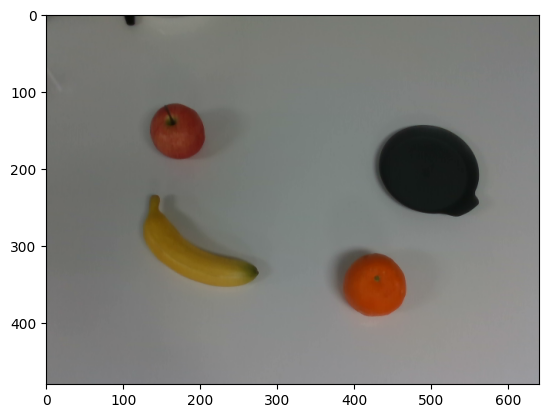

Error: (inverse kinematics) failed to get ik solution


[ INFO] [1724666984.476960956]: Loading robot model 'ur5_robot'...
[ INFO] [1724666984.544451475]: IK Using joint shoulder_link -6.28319 6.28319
[ INFO] [1724666984.544464869]: IK Using joint upper_arm_link -6.28319 6.28319
[ INFO] [1724666984.544473512]: IK Using joint forearm_link -3.14159 3.14159
[ INFO] [1724666984.544481482]: IK Using joint wrist_1_link -6.28319 6.28319
[ INFO] [1724666984.544489368]: IK Using joint wrist_2_link -6.28319 6.28319
[ INFO] [1724666984.544497037]: IK Using joint wrist_3_link -6.28319 6.28319
[ INFO] [1724666984.544507102]: Looking in common namespaces for param name: manipulator/position_only_ik
[ INFO] [1724666984.545001658]: Looking in common namespaces for param name: manipulator/solve_type
[ INFO] [1724666984.545678167]: Using solve type Distance
[ INFO] [1724666985.529412992]: Ready to take commands for planning group manipulator.
Before NMS: 6 boxes
After NMS: 4 boxes


['Apple' 'Fruit' 'Fruit' 'Shampoo']


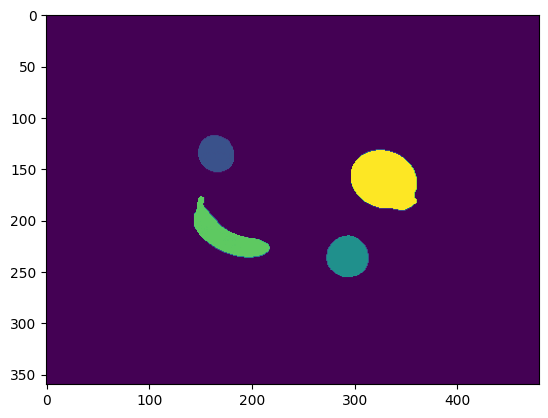

In [3]:
rgb, depth = env.UR5.get_view(env.UR5.ROBOT_INIT_POS, env.UR5.ROBOT_INIT_QUAT, show_img=True)
plt.imshow(rgb)
plt.show()

#classes = ["Apple. Lemon. Orange. Fruit. Basket. Scissors."]
#classes = "Apple. Lemon. Orange. Fruit. Basket. Scissors. Box".replace(' ', '').split('.')
#classes = "Glass.Cup.Bowl.Basket.Plate.Teapot.Shampoo.Clock.Soup case.Toothpaste.Tube.Box".split(".")
#classes = "Glass.Cup.Bowl.Basket.Plate.Teapot.Shampoo.Clock.Soup case.Toothpaste.Tube.Box.Marker.Stapler.Vaseline.Pen.Apple.Oragne.Fruit.Scissors.Box".split(".")
classes = "Glass.Cup.Bowl.Basket.Plate.Teapot.Shampoo.Clock.Toothpaste.Tube.Box.Marker.Stapler.Vaseline.Pen.Apple.Oragne.Fruit.Scissors.Box".split(".")

obs = env.reset(classes)
initRgb = obs['rgb']
initSeg = obs['segmentation']
initTable = renderer.setup(initRgb, initSeg)

print(np.array(classes)[obs['class_id']])
plt.imshow(env.current_obs['segmentation'])
plt.show()

1


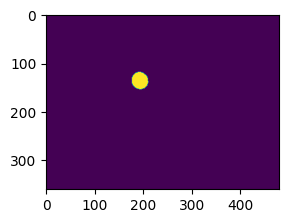

2


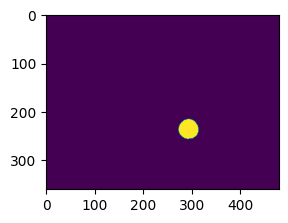

3


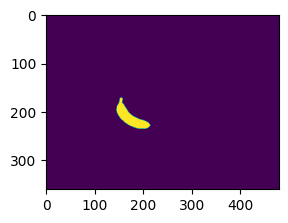

4


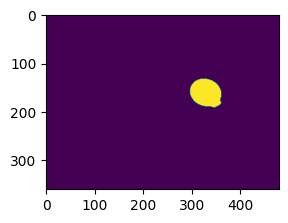

Which objects to remove?  


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0

In [5]:
NB = np.max(env.current_obs['segmentation']).astype(int)
for i in range(1, NB+1):
    print(i)
    plt.figure(figsize=(3,5))
    plt.imshow(env.current_obs['segmentation']==i)
    plt.show()
x = input("Which objects to remove? ")
try:
    remove_indices = [int(idx) for idx in x.replace(" ", "").split(",")]
except:
    remove_indices = []

offset = 0
for idx in remove_indices:
    env.current_obs['segmentation_raw'][env.current_obs['segmentation_raw']==idx-offset] = 0
    env.current_obs['segmentation_raw'][env.current_obs['segmentation_raw']>idx-offset] -= 1

    env.current_obs['segmentation'][env.current_obs['segmentation']==idx-offset] = 0
    env.current_obs['segmentation'][env.current_obs['segmentation']>idx-offset] -= 1

    env.current_obs['class_id'] = np.concatenate([env.current_obs['class_id'][:idx-offset-1], env.current_obs['class_id'][idx-offset:]])
    #env.current_obs['class_id'] = env.current_obs['class_id'][:idx-offset-1] + env.current_obs['class_id'][idx-offset:]
    offset += 1

initRgb = obs['rgb']
initSeg = obs['segmentation']
renderer.setup(initRgb, initSeg)

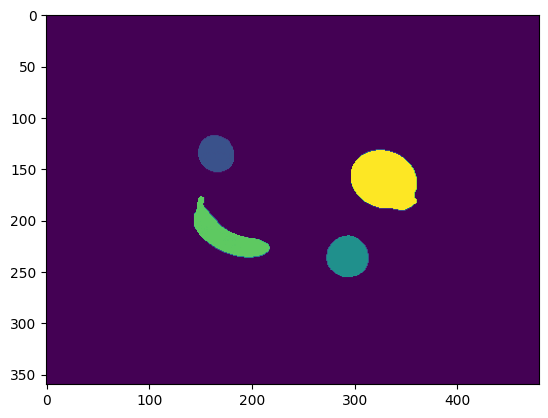

In [4]:
plt.imshow(env.current_obs['segmentation'])

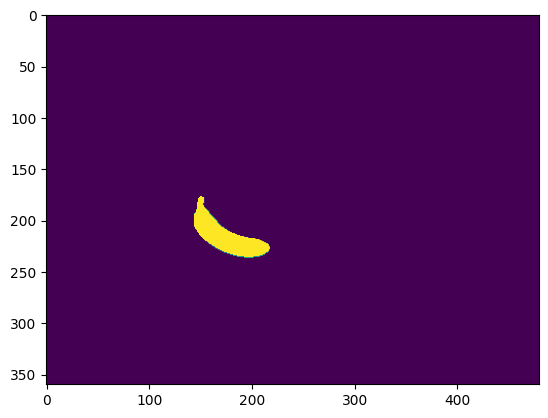

In [5]:
plt.imshow(env.current_obs['segmentation']==3)

In [11]:
import cv2

In [29]:
y, x = np.where(env.current_obs['segmentation']==2)
X = np.array(list(zip(x, y)))
cv2.minAreaRect(X)

((292.5, 236.0), (39.0, 40.0), -0.0)

In [30]:
bx, by, theta = cv2.minAreaRect(X)
print(bx[1]-bx[0])
print(by[1]-by[0])

-56.5
1.0


In [15]:
from ellipse import LsqEllipse

In [31]:
LsqEllipse().fit(X).as_parameters()

((292.70781492737495, 236.3085751637666),
 14.497823799617207,
 14.23847434430783,
 0.9190674604669853)

In [32]:
0.919 * 180 / np.pi

52.65482137252266

In [6]:
action = renderer.convert_action([3, 8, 11, 2])
print(action)

(3, [576, 388], 0.920503471990783)


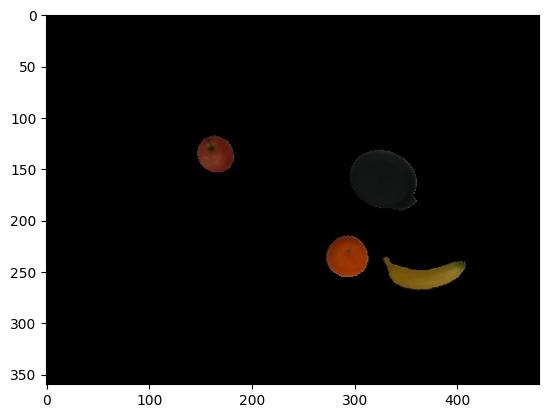

In [7]:
t = [initTable[0].copy(), initTable[1].copy()]
t[0][8,11] = 3
t[1][8,11] = 2
plt.imshow(renderer.getRGB(t))
plt.show()

In [9]:
angle_rend

array([0.        , 1.57079633, 3.14159265])

In [8]:
renderer.objectAngles

[[0.0, 0.0, 0.0, 0.0],
 [90.0, 45.0, -37.2079514379262, 180.0],
 [180.0, 135.0, 52.7920485620738, 270.0]]

In [8]:
renderer.objectAngles[1]

[26.565048217773438, 45.0, -37.25903602778935, 180.0]

In [9]:
obj, pose, angle = action
angle_rend = np.array(renderer.objectAngles)[1] # / 180 * np.pi
env.step(obj, pose, angle, object_angles=angle_rend)

go? y


y
Converting depth to point cloud(s)...
Generating Grasps...


2024-08-26 19:06:51.294389: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-08-26 19:06:51.532332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8801
2024-08-26 19:06:51.574010: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-26 19:06:51.574021: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-08-26 19:06:51.574050: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-26 19:06:51.590882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-08-26 19:06:51.591680: I tensorflow/stream_exec

Generated 6 grasps
# grasps: 0
Rule-based grasp:
width: 22.855189421501382
height: 57.29214964958782
Phi-new: 2.220953238329269
Phi-renderer: -0.6502928548041136
Type: center
grasp: [[ 0.6054194   0.79590648  0.         -0.03431939]
 [-0.79590648  0.6054194   0.         -0.0606161 ]
 [ 0.          0.          1.          0.695     ]
 [ 0.          0.          0.          1.        ]]
goal P: [[-0.59224207 -0.80569996 -0.00983252  0.06635915]
 [-0.74495093  0.55215657 -0.37439499 -0.51597738]
 [ 0.3070791  -0.21440771 -0.92721749  0.21599341]
 [ 0.          0.          0.          1.        ]]
goal P: [[-0.59224207 -0.80569996 -0.00983252  0.06586753]
 [-0.74495093  0.55215657 -0.37439499 -0.53469713]
 [ 0.3070791  -0.21440771 -0.92721749  0.16963253]
 [ 0.          0.          0.          1.        ]]


go? y


y


Error: (inverse kinematics) failed to get ik solution


go? y


y


Error: (inverse kinematics) failed to get ik solution


go? y


y


Error: (inverse kinematics) failed to get ik solution


go? y


y


go? y


y


Error: (inverse kinematics) failed to get ik solution


go? y


y


Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.01641708 -0.99981682 -0.00983252 -0.27492456]
 [-0.92719772 -0.01154275 -0.37439499 -0.32661386]
 [ 0.37421289  0.01526317 -0.92721749  0.26178525]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.01641708 -0.99981682 -0.00983252 -0.27541619]
 [-0.92719772 -0.01154275 -0.37439499 -0.34533361]
 [ 0.37421289  0.01526317 -0.92721749  0.21542437]
 [ 0.          0.          0.          1.        ]]


go? y


y
Find solutions: [-2.59223342 -1.67719591  2.19450951 -2.30454183 -1.25121176  3.71145827]
[-0.27492456 -0.32661386  0.26178525]
[ 0.69913823 -0.68906774  0.13029623  0.13933512]


go? y


y
Find solutions: [-2.55303741 -1.56228304  2.23327327 -2.47068739 -1.25986874  3.75166852]
[-0.27541619 -0.34533361  0.21542437]
[ 0.69913823 -0.68906774  0.13029623  0.13933512]


go? y


y


go? y


y
Find solutions: [-2.59223342 -1.67719591  2.19450951 -2.30454183 -1.25121176  3.71145827]
[-0.27492456 -0.32661386  0.26178525]
[ 0.69913823 -0.68906774  0.13029623  0.13933512]


go? y


y


Error: (inverse kinematics) failed to get ik solution


Before NMS: 7 boxes
After NMS: 4 boxes


{'rgb_raw': array([[[ 98,  95,  90],
         [ 98,  95,  90],
         [ 99,  96,  91],
         ...,
         [126, 123, 120],
         [123, 122, 122],
         [123, 122, 122]],
 
        [[ 98,  95,  90],
         [ 98,  95,  90],
         [ 98,  95,  90],
         ...,
         [126, 123, 120],
         [123, 123, 119],
         [123, 123, 119]],
 
        [[ 98,  95,  90],
         [ 98,  95,  90],
         [ 98,  95,  90],
         ...,
         [126, 123, 120],
         [124, 124, 120],
         [124, 124, 120]],
 
        ...,
 
        [[128, 124, 125],
         [128, 124, 125],
         [126, 125, 125],
         ...,
         [155, 154, 158],
         [156, 155, 159],
         [156, 155, 159]],
 
        [[128, 124, 125],
         [128, 124, 125],
         [126, 125, 125],
         ...,
         [155, 154, 158],
         [156, 155, 159],
         [156, 155, 159]],
 
        [[129, 125, 126],
         [128, 124, 125],
         [126, 125, 125],
         ...,
         [155, 15

In [15]:
env.check_picknplace(6, stop=False)

Converting depth to point cloud(s)...
Generating Grasps...
Generated 1 grasps
skipped gripper openings 0.0725269690155983
# grasps: 0
Rule-based grasp:
width: 46.753473398735075
height: 42.02628951277834
Type: boundary
point: [335 179]
grasp: [[-1.          0.          0.          0.01477549]
 [ 0.         -1.          0.         -0.07482639]
 [ 0.          0.          1.          0.7       ]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.9998442   0.01531249 -0.0087804   0.01790205]
 [ 0.01090794 -0.92709056 -0.37467819 -0.53176831]
 [-0.01387748  0.37452407 -0.92711315  0.21756319]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.9998442   0.01531249 -0.0087804   0.01746303]
 [ 0.01090794 -0.92709056 -0.37467819 -0.55050222]
 [-0.01387748  0.37452407 -0.92711315  0.17120753]
 [ 0.          0.          0.          1.        ]]


Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution
Error: (inverse kinematics) failed to get ik solution


In [9]:
env.check_picknplace(2, stop=False)

Converting depth to point cloud(s)...
Generating Grasps...


2024-08-23 14:26:02.089619: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-08-23 14:26:02.329920: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8801
2024-08-23 14:26:02.375494: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-23 14:26:02.375509: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-08-23 14:26:02.375549: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-23 14:26:02.394481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-08-23 14:26:02.395273: I tensorflow/stream_exec

Generated 0 grasps
skipping obj 2 since  np.any(pc_segments[k]) True and np.any(contact_pts[j]) is False


KeyError: 2

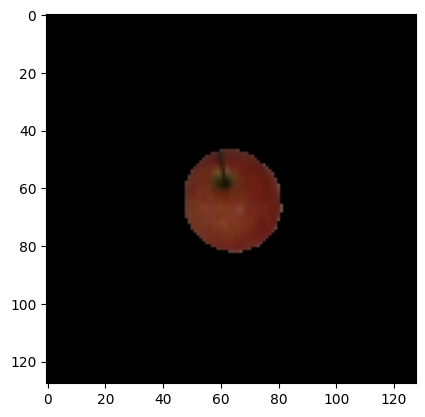

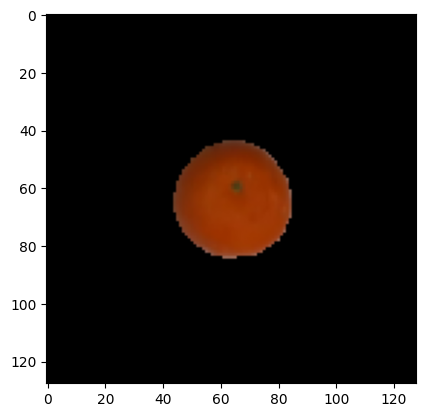

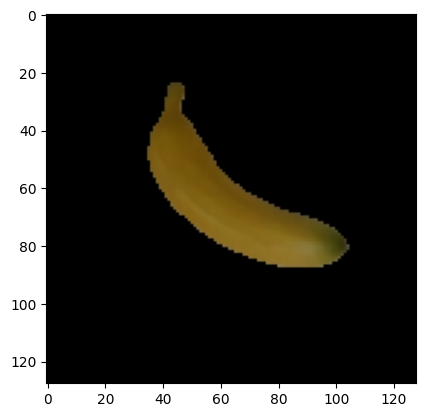

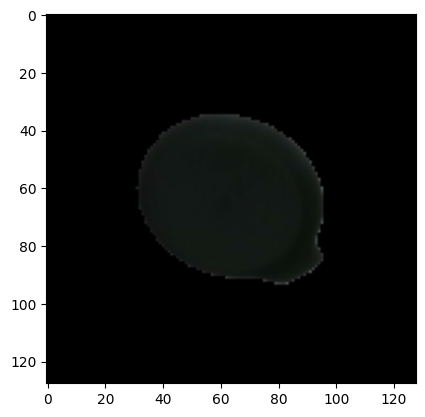

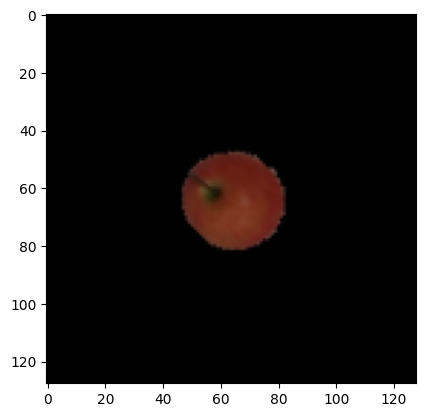

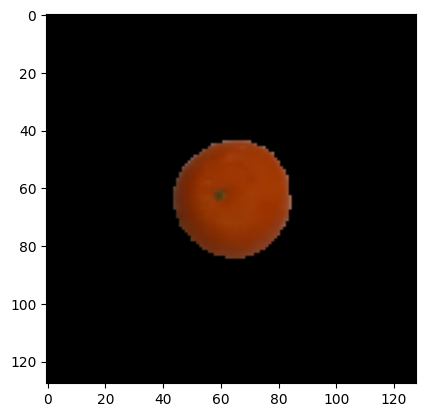

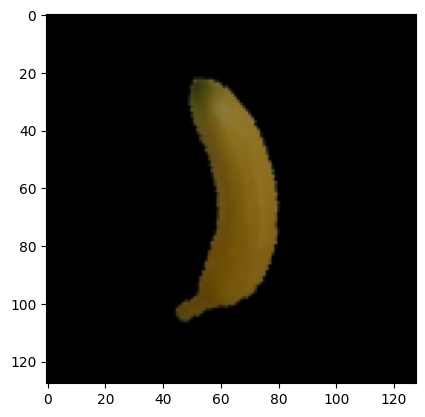

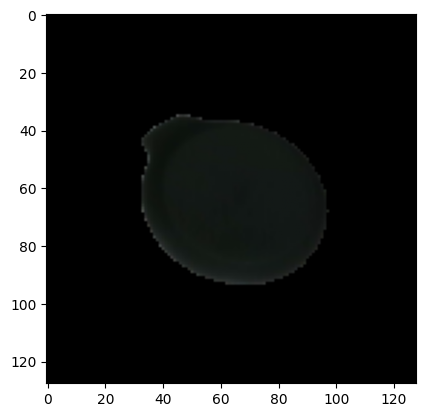

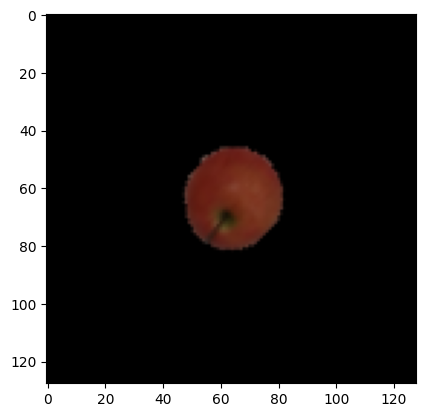

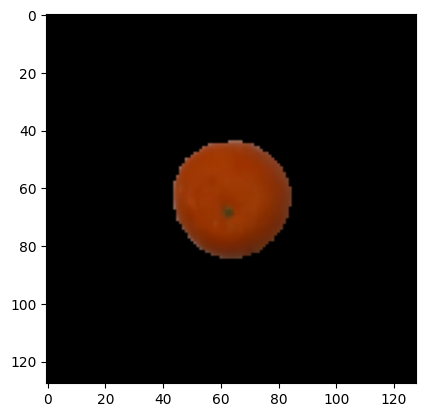

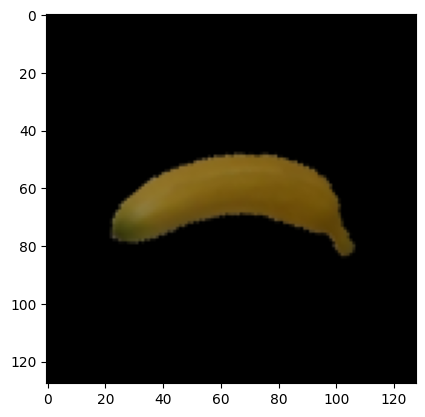

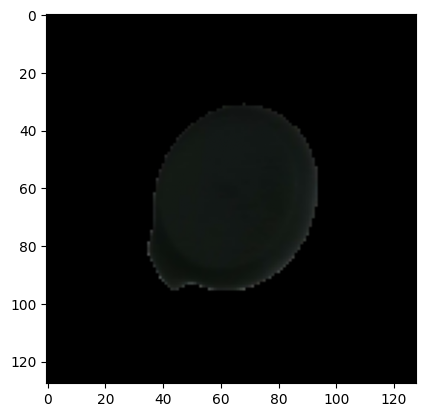

In [12]:
for x in renderer.objectPatches:
    for y in x:
        plt.imshow(y/255.)
        plt.show()

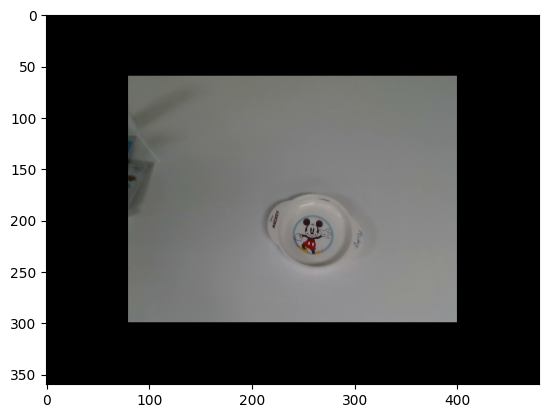

In [36]:
plt.imshow(initRgb)

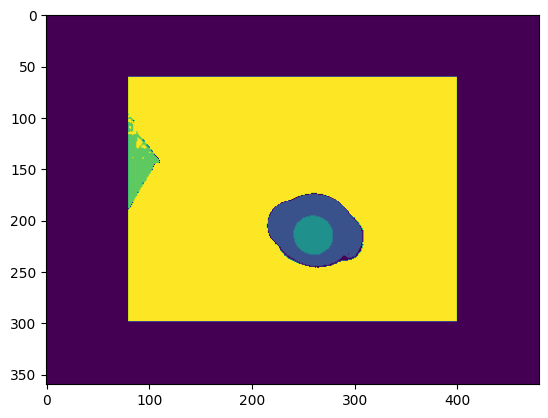

In [37]:
plt.imshow(env.current_obs['segmentation'])

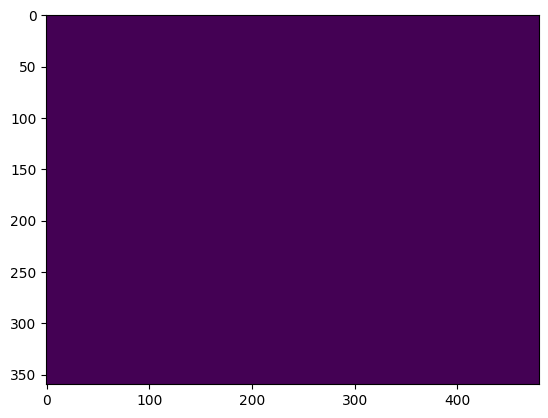

In [100]:
plt.imshow(env.current_obs['segmentation']==7)

In [27]:
from utils_sim2real import inverse_projection

In [48]:
from transform_utils import quat2mat, euler2quat

In [50]:
quat2mat(euler2quat([0, 0, phi]))

array([[ 0.83640103,  0.548118  ,  0.        ],
       [-0.548118  ,  0.83640103, -0.        ],
       [-0.        ,  0.        ,  1.        ]])

In [94]:
quat2mat(euler2quat([0, 0, np.pi]))

array([[-9.99999881e-01, -1.22464672e-16,  0.00000000e+00],
       [ 1.22464672e-16, -9.99999881e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
inverse_projection(depth, pixel, env.RS.K_rs, env.RS.D_rs)

In [43]:
inverse_projection(env.current_obs['depth_raw'], np.array([my, mx]).astype(int), env.RS.K_rs, env.RS.D_rs)

array([0.02452531, 0.03947758, 0.654     ])

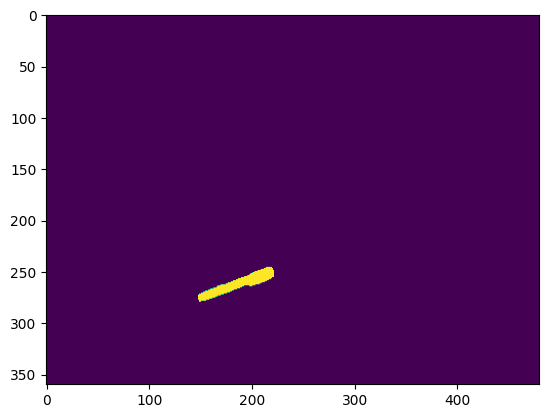

In [259]:
plt.imshow(env.current_obs['segmentation']==3)

In [266]:
px.mean()

50.229573780581624

96

In [264]:
py

array([258, 258, 258, ..., 348, 348, 348])

In [12]:
from ellipse import LsqEllipse

In [260]:
X = np.array(list(zip(*np.where(env.current_obs['segmentation']==3))))
reg = LsqEllipse().fit(X)

In [261]:
center, width, height, phi = reg.as_parameters()

In [262]:
width

30.78927501557659

In [263]:
height

4.361103683836783

In [249]:
phi

1.0146739839679113

In [82]:
from utils_contactgraspnet import form_T

In [199]:
py, px = np.where(env.current_obs['segmentation_raw']==5)
my, mx = np.mean(py), np.mean(px)
print(my, mx)

t = inverse_projection(env.current_obs['depth_raw'], np.array([mx, my]).astype(int), env.RS.K_rs, env.RS.D_rs)
print(t)

rot = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
rot = np.dot(quat2mat(euler2quat([0, 0, -phi])), rot)
#rot = np.dot(quat2mat(euler2quat([0, 0, phi+np.pi/2])), rot)
grasp_rule = form_T(rot, t)

302.1523311278658 50.229573780581624
[-0.22705564  0.04825257  0.509     ]


In [200]:
grasp_rule

array([[-0.52789688, -0.84930849,  0.        , -0.22705564],
       [ 0.84930849, -0.52789688,  0.        ,  0.04825257],
       [ 0.        ,  0.        ,  1.        ,  0.509     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

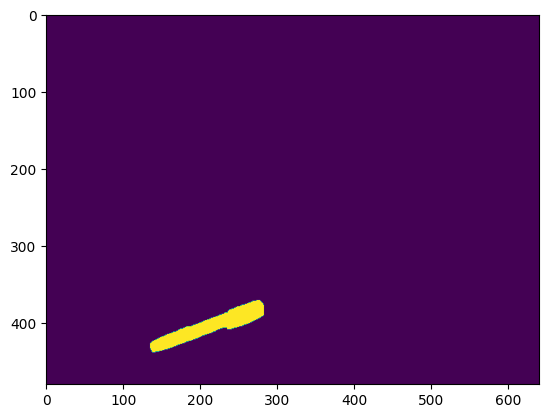

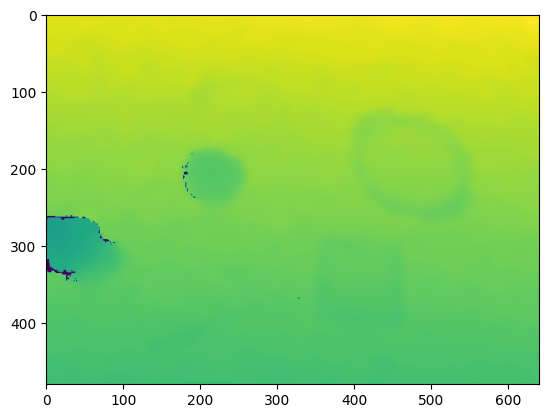

In [201]:
target = 5
plt.imshow(env.current_obs['segmentation_raw']==3)
plt.show()
plt.imshow(env.current_obs['depth_raw'])

In [89]:
grasp1 = np.array([[-0.16897786,  0.9830221,  -0.07151271, -0.06034984],
     [-0.9392518,  -0.13861142,  0.31399524,  0.00628405],
     [ 0.2987518,   0.12022669,  0.94672745,  0.5163116 ],
     [ 0.,          0.,          0.,          1.        ]])
pos, quat = env.UR5.get_goal_from_grasp(grasp1, env.init_eef_P)
env.UR5.get_view(pos, quat)

goal P: [[ 0.18120204 -0.98171418  0.05833629  0.09167501]
 [-0.98091652 -0.18466935 -0.06082778 -0.46820419]
 [ 0.07048841 -0.04620092 -0.99644202  0.15190216]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.61912596 -1.48458576  2.06795812 -2.21224856 -1.50955129  4.48153562]
[ 0.09167501 -0.46820419  0.22      ]
[ 0.76849097 -0.63846902  0.04190834  0.00475831]


(None, None)

In [134]:
grasp_rule

array([[-0.08093613,  0.99671924,  0.        , -0.04213268],
       [-0.99671924, -0.08093613,  0.        ,  0.10331847],
       [ 0.        ,  0.        ,  1.        ,  0.625     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [142]:
from transform_utils import mat2euler

In [149]:
euler2quat([np.pi, 0, mat2euler(quat2mat(quat))[2]])

[0.7429908426495786,
 -0.6693015820531647,
 -4.098290200628339e-17,
 4.549506786233006e-17]

In [148]:
euler2quat([np.pi, 0, phi+np.pi/2])

[0.7351653216403482,
 0.6778878593524473,
 4.150865985684129e-17,
 4.501589289954934e-17]

In [146]:
euler2quat(mat2euler(quat2mat(quat)))

[0.7264665351996841,
 -0.6604346660227383,
 0.12446031261715487,
 0.1434644755109793]

In [147]:
mat2euler(quat2mat(quat))

array([ 3.0941548, -0.3793646, -1.4665368], dtype=float32)

In [138]:
quat

array([ 0.72646654, -0.66043467,  0.12446034,  0.14346444])

In [202]:
grasp_rule
pos, quat = env.UR5.get_goal_from_grasp(grasp_rule, env.init_eef_P)
env.UR5.get_view(pos, quat)

goal P: [[ 0.51416343  0.85762756 -0.01053399  0.25659997]
 [ 0.79380732 -0.48048148 -0.37283785 -0.4247679 ]
 [-0.32481741  0.18333763 -0.92783701  0.14034708]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.22608399 -1.41995168  2.09835267 -2.60740685 -1.70712411  2.4328928 ]
[ 0.25659997 -0.4247679   0.22      ]
[ 0.85476334  0.48300932 -0.09808309  0.16266939]


(None, None)

In [204]:
grasp_rule
pos, quat = env.UR5.get_goal_from_grasp(grasp_rule, env.init_eef_P)
newquat = euler2quat([np.pi, 0, mat2euler(quat2mat(quat))[2]])
env.UR5.get_view(pos, newquat)

goal P: [[ 0.51416343  0.85762756 -0.01053399  0.25659997]
 [ 0.79380732 -0.48048148 -0.37283785 -0.4247679 ]
 [-0.32481741  0.18333763 -0.92783701  0.14034708]
 [ 0.          0.          0.          1.        ]]


Error: (inverse kinematics) failed to get ik solution


(None, None)

In [205]:
env.UR5.move_to_joints(env.INIT_JOINTS)

In [80]:
quat2mat(euler2quat([0, 0, -np.pi/2]))

array([[ 0.,  1.,  0.],
       [-1.,  0., -0.],
       [-0.,  0.,  1.]])

In [78]:
quat2mat([1,0,0,0])

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        , -0.99999988,  0.        ],
       [ 0.        ,  0.        , -0.99999988]])

In [79]:
grasp1 = np.array([[1,  0,  0, -0.06034984],
     [0,  -1,  0,  0.00628405],
     [ 0,   0,  -1,  0.5163116 ],
     [ 0.,          0.,          0.,          1.        ]])
env.UR5.get_goal_from_grasp(grasp1, env.init_eef_P)

goal P: [[-0.99983762  0.0158002   0.00866524  0.09167501]
 [-0.01143093 -0.92782516  0.37284007 -0.46820419]
 [ 0.01393077  0.37268046  0.92785511  0.15190216]
 [ 0.          0.          0.          1.        ]]


(array([ 0.09167501, -0.46820419,  0.15190216]),
 array([-0.00575388, -0.18984024, -0.98177365,  0.00693417]))

In [35]:
env.current_obs.keys()

dict_keys(['rgb_raw', 'depth_raw', 'segmentation_raw', 'rgb', 'depth', 'segmentation', 'class_id'])

In [ ]:
env.check_picknplace(3, stop=False)

Converting depth to point cloud(s)...
Generating Grasps...


2024-08-21 18:39:27.094466: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-08-21 18:39:27.368572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8801
2024-08-21 18:39:27.410197: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-21 18:39:27.410207: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-08-21 18:39:27.410235: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-21 18:39:27.428089: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-08-21 18:39:27.428856: I tensorflow/stream_exec

Generated 8 grasps
# grasps: 1
GCN grasp:
grasp: [[-0.5257469   0.85050565 -0.01517793 -0.13274644]
 [-0.5543827  -0.32905394  0.7644497   0.08294402]
 [ 0.64517444  0.41032144  0.6445047   0.5243278 ]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.52773155 -0.84940551 -0.00311573  0.16219342]
 [-0.75000126 -0.46768788  0.46772466 -0.44708088]
 [-0.39874512 -0.24449627 -0.88386888  0.20343614]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.52773155 -0.84940551 -0.00311573  0.16203763]
 [-0.75000126 -0.46768788  0.46772466 -0.42369465]
 [-0.39874512 -0.24449627 -0.88386888  0.15924269]
 [ 0.          0.          0.          1.        ]]
Find solutions: [-1.46276796 -1.41916394  1.87435615 -1.54138649 -1.52344704  4.25200802]
[ 0.16219342 -0.44708088  0.22      ]
[-0.84842326  0.47128797  0.11841402  0.20986602]
Find solutions: [-1.45780957 -1.46987581  1.93283701 -1.5493685  -1.5211376   4.25640113]
[ 0.16203763 -0.42369465  0.22      ]
[-0.84842326  

Error: (inverse kinematics) failed to get ik solution


In [ ]:
# n_obj = len(renderer.objectPatches)
for o in range(n_obj):
    env.check_picknplace(o+1, stop=False)

In [17]:
action = renderer.convert_action([2, 8, 11, 0])
print(action)

(2, [576, 388], 0.0)


In [7]:
action = renderer.convert_action([2, 8, 11, 1])
print(action)

(2, [576, 388], 0.8156919536922359)


In [10]:
action = renderer.convert_action([2, 8, 11, 2])
print(action)

(2, [576, 388], 2.3864882804871326)


In [8]:
obj, pose, angle = action
env.step(obj, pose, angle)

go? y


y
Converting depth to point cloud(s)...
Generating Grasps...


2024-07-31 17:08:32.198497: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-07-31 17:08:32.435415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8801
2024-07-31 17:08:32.476586: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-07-31 17:08:32.476598: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-07-31 17:08:32.476628: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-07-31 17:08:32.492649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-31 17:08:32.493498: I tensorflow/stream_exec

Generated 14 grasps
# grasps: 10
goal P: [[ 0.97201052 -0.22891196  0.0528662   0.14851825]
 [-0.23364229 -0.9654553   0.11535767 -0.61495747]
 [ 0.02463321 -0.12448068 -0.99191627  0.27167684]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.97201052 -0.22891196  0.0528662   0.15116156]
 [-0.23364229 -0.9654553   0.11535767 -0.60918959]
 [ 0.02463321 -0.12448068 -0.99191627  0.22208103]
 [ 0.          0.          0.          1.        ]]


go? y


y
Find solutions: [-1.5150491  -1.17652524  1.48101366 -1.7626164  -1.51155007  3.4283529 ]
[ 0.14851825 -0.61495747  0.27167684]
[-0.99113344  0.11667306 -0.01954818  0.06049597]


go? y


y
Find solutions: [-1.51032102 -1.14598644  1.57188213 -1.88430369 -1.51101911  3.43305952]
[ 0.15116156 -0.60918959  0.22208103]
[-0.99113344  0.11667306 -0.01954818  0.06049597]


go? y


y


go? y


y
Find solutions: [-1.5150491  -1.17652524  1.48101366 -1.7626164  -1.51155007  3.4283529 ]
[ 0.14851825 -0.61495747  0.27167684]
[-0.99113344  0.11667306 -0.01954818  0.06049597]


go? y


y


Error: (inverse kinematics) failed to get ik solution


goal P: [[ 0.86248363  0.4136268  -0.29160753 -0.20964525]
 [ 0.44232662 -0.89608105  0.03722933 -0.43878445]
 [-0.24590493 -0.16109546 -0.95581329  0.27958383]
 [ 0.          0.          0.          1.        ]]
goal P: [[ 0.86248363  0.4136268  -0.29160753 -0.22422562]
 [ 0.44232662 -0.89608105  0.03722933 -0.43692299]
 [-0.24590493 -0.16109546 -0.95581329  0.23179316]
 [ 0.          0.          0.          1.        ]]


go? y


y
Find solutions: [-2.19831944 -1.52560246  1.97187757 -2.16361356 -1.83165538  2.04183459]
[-0.20964525 -0.43878445  0.27958383]
[-0.96363606 -0.22206346  0.13944902  0.0514522 ]


go? y


y
Find solutions: [-2.22562003 -1.45405209  2.03507829 -2.30551195 -1.82757223  2.01391077]
[-0.22422562 -0.43692299  0.23179316]
[-0.96363606 -0.22206346  0.13944902  0.0514522 ]


go? y


y


go? y


y
Find solutions: [-2.19831944 -1.52560246  1.97187757 -2.16361356 -1.83165538  2.04183459]
[-0.20964525 -0.43878445  0.27958383]
[-0.96363606 -0.22206346  0.13944902  0.0514522 ]


go? y


y


Error: (inverse kinematics) failed to get ik solution


Before NMS: 6 boxes
After NMS: 2 boxes


{'rgb_raw': array([[[103, 107, 100],
         [105, 109, 102],
         [105, 109, 102],
         ...,
         [118, 117, 117],
         [112, 118, 116],
         [112, 118, 116]],
 
        [[103, 107, 100],
         [105, 109, 102],
         [105, 109, 102],
         ...,
         [117, 118, 114],
         [115, 119, 114],
         [114, 118, 113]],
 
        [[103, 107, 100],
         [105, 109, 102],
         [105, 109, 102],
         ...,
         [117, 118, 112],
         [115, 119, 112],
         [115, 119, 112]],
 
        ...,
 
        [[121, 121, 123],
         [121, 121, 123],
         [119, 119, 121],
         ...,
         [150, 146, 151],
         [150, 145, 153],
         [150, 145, 153]],
 
        [[121, 121, 123],
         [121, 121, 123],
         [121, 121, 123],
         ...,
         [148, 146, 153],
         [148, 146, 153],
         [148, 146, 153]],
 
        [[121, 121, 123],
         [121, 121, 123],
         [121, 121, 123],
         ...,
         [148, 14

In [11]:
classes

['Glass',
 'Cup',
 'Bowl',
 'Basket',
 'Plate',
 'Teapot',
 'Shampoo',
 'Clock',
 'Soup case',
 'Toothpaste',
 'Tube',
 '']

In [12]:
classes = ['Apple', 'Ball', 'Lemon', 'Scissors']

In [63]:
classes = ['Apple. Ball. Lemon. Scissors.']

In [14]:
detections = env.GSAM.get_masks(rgb, classes)

Before NMS: 10 boxes
After NMS: 7 boxes


In [15]:
detections.class_id

array([1, 1, 9, 6, 6, 8, 8])

In [20]:
classes

['Glass',
 'Cup',
 'Bowl',
 'Basket',
 'Plate',
 'Teapot',
 'Shampoo',
 'Clock',
 'Soup case',
 'Toothpaste',
 'Tube',
 '']

In [17]:
np.array(classes)[detections.class_id]

array(['Cup', 'Cup', 'Toothpaste', 'Shampoo', 'Shampoo', 'Soup case',
       'Soup case'], dtype='<U10')

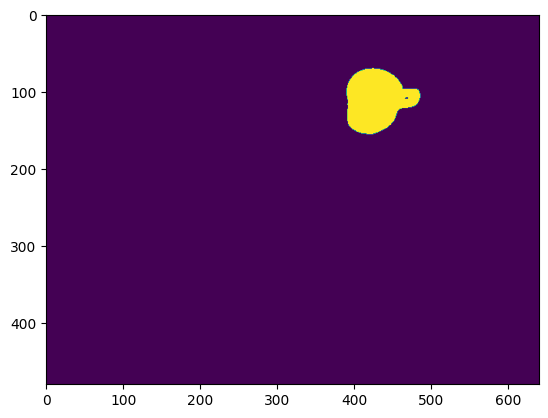

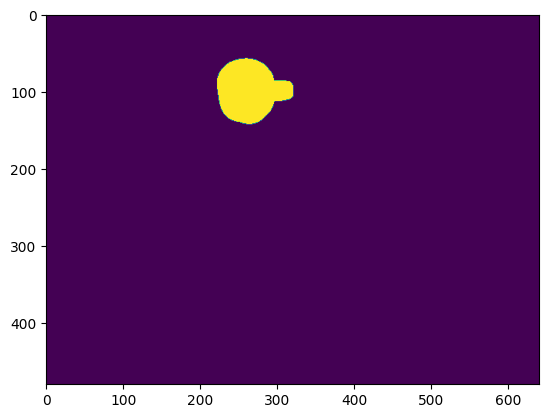

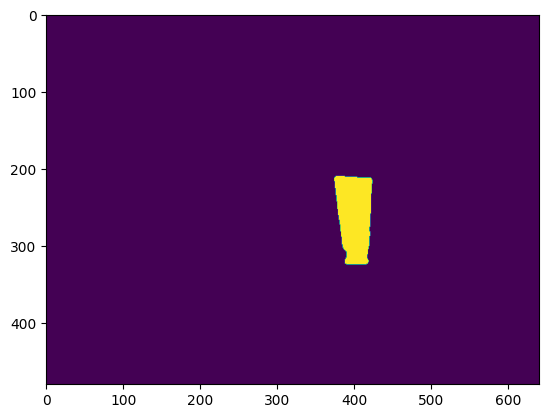

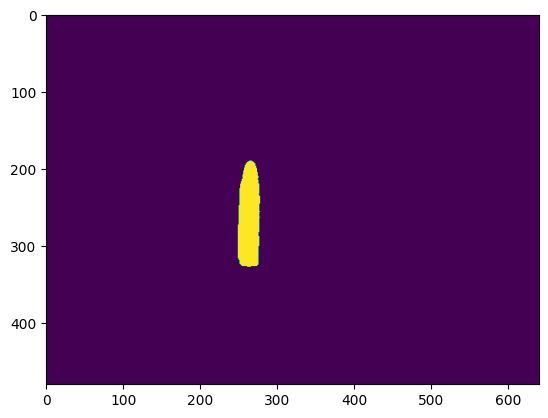

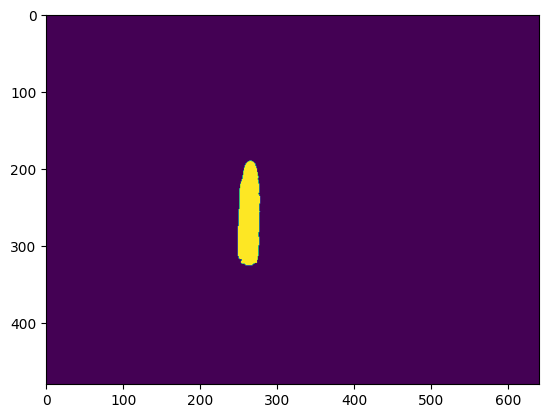

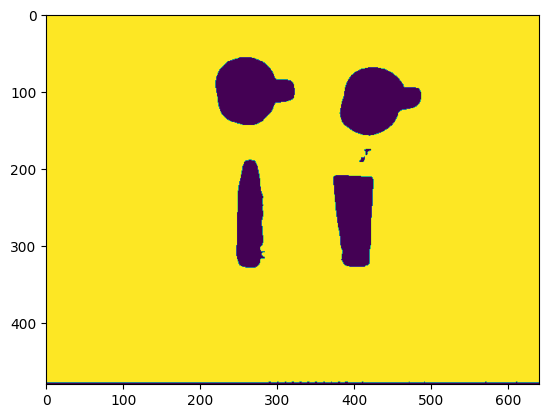

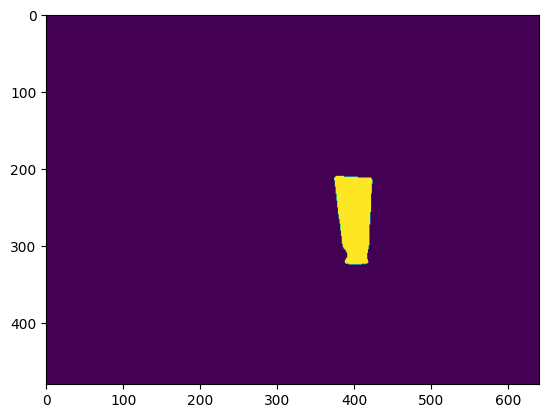

In [19]:
for m in detections.mask:
    plt.imshow(m)
    plt.show()

In [12]:
from transform_utils import euler2quat

In [9]:
renderer.ratio

array([30., 32.])

0 0 0.5609279318563563
0 1 0.45242023731403347
0 2 0.4740542561808384
0 3 0.43156006192210794
0 4 0.39592123243336186
0 5 0.36825872376252566
0 6 0.34608852712584776
0 7 0.3401445043301086
0 8 0.29932326001641557
0 9 0.3614181690884202
0 10 0.3855441627171548
0 11 0.3723017186721898
0 12 None
0 13 None
0 14 None
1 0 0.5540942899234432
1 1 0.49499613282236743
1 2 0.4542648256512652
1 3 0.40410840379892793
1 4 0.36033454605297677
1 5 0.322391746665277
1 6 0.3012951870132001
1 7 0.29212240252467986
1 8 0.29888632523609415
1 9 0.31851623638450327
1 10 0.35170315574303496
1 11 0.391182092464924
1 12 None
1 13 None
1 14 None
2 0 0.3970265641722498
2 1 0.3496767593319371
2 2 0.3110068429076261
2 3 0.26882787513132506
2 4 0.23294861169539352
2 5 0.2014860264533779
2 6 0.17719635247867732
2 7 0.16946033780235886
2 8 0.17588327616188784
2 9 0.1993488904597696
2 10 0.2288013050712263
2 11 0.2635043474686208
2 12 None
2 13 None
2 14 None
3 0 0.3928709556208575
3 1 0.3427709720401585
3 2 0.29754744

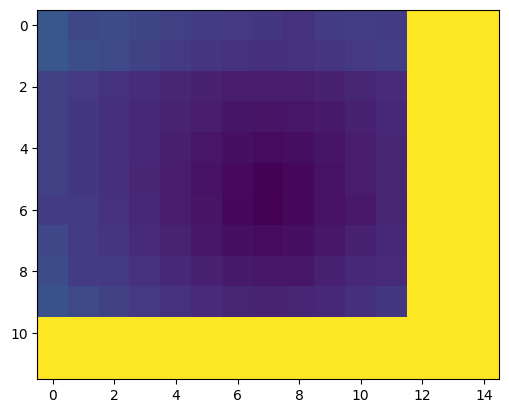

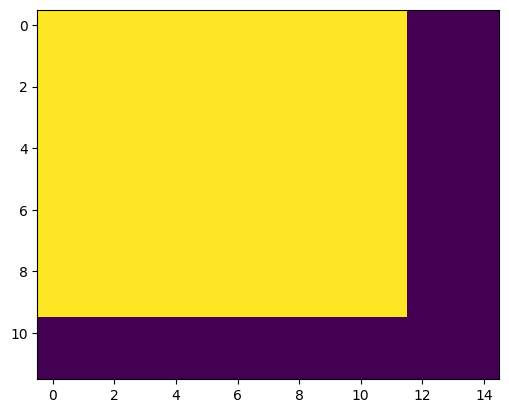

In [19]:
distmap = np.zeros([12, 15])
feasiblemap = np.zeros([12, 15])
depth = obs['depth_raw']
for y in range(12):
    for x in range(15):
        _, target_position, _ = renderer.convert_action([1, y, x, 0])
        try:
            target_pose = inverse_projection(depth, np.array(target_position), env.RS.K_rs, env.RS.D_rs)
            d = np.sqrt(target_pose[0]**2 + target_pose[1]**2)
            print(y, x, d)
        except:
            print(y, x, None)
            d = 2
        distmap[y, x] = d
        feasiblemap[y, x] = (d<0.8)
plt.imshow(distmap)
plt.show()
plt.imshow(feasiblemap)
plt.show()

In [5]:
renderer.convert_action([1, 0, 0, 0])

(1, [-128, -92], 0.0)

In [13]:
depth = obs['depth_raw']
target_position = [320, 268]
target_pose = inverse_projection(depth, np.array(target_position), env.RS.K_rs, env.RS.D_rs)

In [14]:
target_pose

array([-0.00179624,  0.02014777,  0.516     ])